# Introduction to Time Series Analysis with Transformers

The transformative landscape of deep learning has witnessed monumental strides in the recent past, particularly in the domain of Natural Language Processing (NLP). Central to this revolution has been the advent of transformer architectures, which, with their attention mechanisms, have pushed the boundaries of what's achievable in tasks like machine translation, sentiment analysis, and language modeling. However, while transformers initially rose to prominence primarily within the realm of NLP, their applicability isn't restricted to just textual data. A growing wave of interest has emerged around leveraging these models for time-series predictions—a challenge that, though numerically distinct, bears conceptual resemblance to understanding sequences in language.

In time-series prediction, the objective often centers around forecasting future values based on historical data. This could involve predicting stock prices, weather patterns, or even the consumption of electricity in a region. At its core, this is a sequence-to-sequence task, where the past values form an input sequence and the future values to be predicted form an output sequence. Now, consider the similarities with machine translation in NLP, where an input sequence (sentence) in one language is translated into an output sequence in another language. Both scenarios require the model to recognize patterns, interdependencies, and context across sequences.

References:

[Transformer-Based Time Series with PyTorch](https://www.youtube.com/watch?v=NGzQpphf_Vc&t=1s&ab_channel=JeffHeaton)

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Loading Sun Spot Data for a Transformer Time Series
We will look at the same sunspot data as the previous section. However, this time we will use a transformer to predict. You can find the data files needed for this example at the following location.

* Sunspot Data Files
* Download Daily Sunspots - 1/1/1818 to now.

In [2]:
col_names = [
    'year', 
    'month', 
    'day', 
    'dec_year', 
    'sunspot_value',
    'sunspot_number_error', 
    'observation', # 1=vaild, 0=invalid
    'unused1',
    ]

df_raw = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/SN_d_tot_V2.0.csv",
    sep=';', 
    header=None, 
    names=col_names,
    na_values=['-1'], 
    index_col=False,
    )

df_raw.head()

,year,month,day,dec_year,sunspot_value,sunspot_number_error,observation,unused1
0,1818,1,1,1818.001,-1,NaN,0,1
1,1818,1,2,1818.004,-1,NaN,0,1
2,1818,1,3,1818.007,-1,NaN,0,1
3,1818,1,4,1818.010,-1,NaN,0,1
4,1818,1,5,1818.012,-1,NaN,0,1


In [3]:
# Find the first index where observations are consistently valid
# There's a lot of missing data between 1818 and 1848 and we want to skip this
start_id = df_raw.index[df_raw['observation'] == 0][-1] + 1
df = df_raw[start_id:].copy()
df.index = pd.to_datetime(df[['year', 'month', 'day']])
df['sunspot_value'] = df['sunspot_value'].astype(float)
df_train = df[df['year'] < 2000]
df_test = df[df['year'] >= 2000]

In [4]:
df_train['sunspot_value']

1848-12-23    353.0
1848-12-24    240.0
1848-12-25    275.0
1848-12-26    352.0
1848-12-27    268.0
              ...  
1999-12-27     95.0
1999-12-28     85.0
1999-12-29    103.0
1999-12-30     66.0
1999-12-31     79.0
Name: sunspot_value, Length: 55160, dtype: float64

In [5]:
scaler = StandardScaler()
spots_train = scaler.fit_transform(df_train['sunspot_value'].values.reshape(-1, 1))
spots_test = scaler.transform(df_test['sunspot_value'].values.reshape(-1, 1))

# Dataset Creation

In [6]:
# Sequence Data Preparation
SEQUENCE_SIZE = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
def to_sequences(seq_size, obs):
    x = []
    y = []
    for i in range(len(obs) - seq_size):
        window = obs[i:(i + seq_size)]
        forecast = obs[i + seq_size]
        x.append(window)
        y.append(forecast)
    x = torch.tensor(np.array(x), dtype=torch.float32).view(-1, seq_size, 1)
    y = torch.tensor(np.array(y), dtype=torch.float32).view(-1, 1)
    return x, y

In [8]:
x_train, y_train = to_sequences(SEQUENCE_SIZE, spots_train)
x_test, y_test = to_sequences(SEQUENCE_SIZE, spots_test)

In [9]:
train_indices = df_train.index[SEQUENCE_SIZE:]
test_indices = df_test.index[SEQUENCE_SIZE:]

In [10]:
print(f"First Sequence of {SEQUENCE_SIZE} months: {x_train[0]}")
print(f"First Target Value: {y_train[0]}")

First Sequence of 10 months: tensor([[3.3709],
        [1.9389],
        [2.3825],
        [3.3583],
        [2.2937],
        [2.5092],
        [3.2442],
        [3.2062],
        [1.9136],
        [2.5345]])
First Target Value: tensor([2.6232])


In [11]:
# Setup data loaders for batch
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Setup Model

The following code constructs the actual transformer-based model for time series prediction. The model is constructed to accept the following parameters.

* input_dim: The dimension of the input data, in this case we use only one input, the number of sunspots.
* d_model: The number of features in the transformer model's internal representations (also the size of embeddings). This controls how much a model can remember and process.
* nhead: The number of attention heads in the multi-head self-attention mechanism.
* num_layers: The number of transformer encoder layers. dropout: The dropout probability.

In [12]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int = 512, dropout: float = 0.1, max_seq_len: int = 5000):
        """Initialize the PositionalEncoding module."""
        super().__init__()
        self.embed_dim = d_model
        self.max_seq_len = max_seq_len
        self.dropout = nn.Dropout(dropout)
        # Precompute the positional encoding matrix
        positional_encoding = torch.zeros(max_seq_len, d_model)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        division_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        positional_encoding[:, 0::2] = torch.sin(position * division_term)
        positional_encoding[:, 1::2] = torch.cos(position * division_term)
        positional_encoding = positional_encoding.unsqueeze(0)
        self.register_buffer('positional_encoding', positional_encoding) # Register the positional encoding as buffer to not include it in the model's state_dict

    def forward(self, x):
        x += self.positional_encoding[:x.size(0), :]
        x = self.dropout(x)
        return x

torch.Size([100, 512])


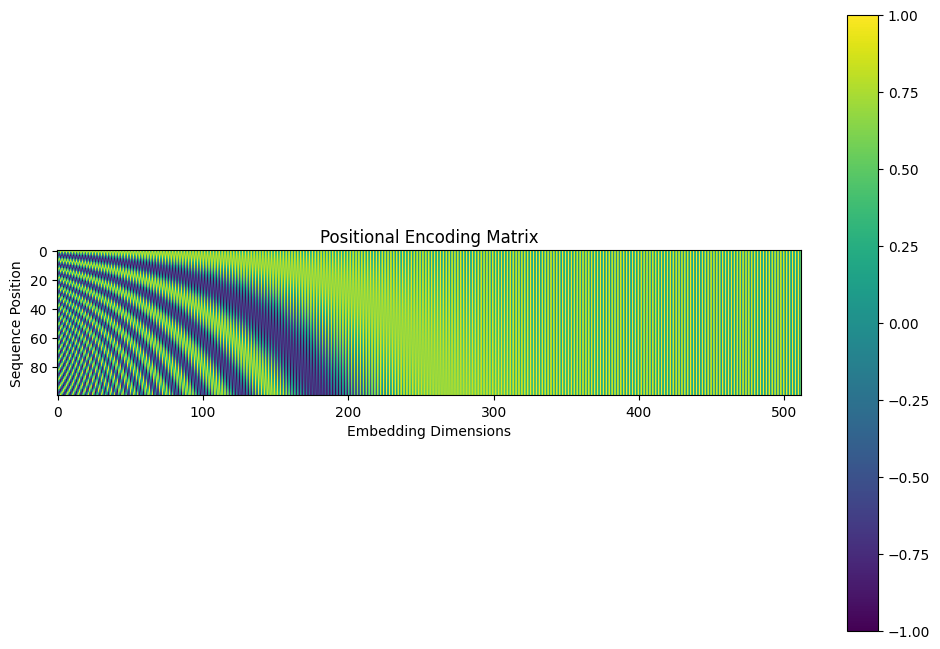

In [13]:
# Create an instance of the PositionalEncoding class and plot the positional encoding matrix
# Size (batch_size, max_seq_len, embed_dim) -> (max_seq_len, embed_dim)
# Example: (1, 100, 512) -> (100, 512)
positional_encoding = PositionalEncoding(d_model=512, max_seq_len=100)
# Plot the positional encoding matrix
positional_tensor = positional_encoding.positional_encoding.squeeze(0)
print(positional_tensor.shape)
plt.figure(figsize=(12, 8))
plt.imshow(positional_tensor)
plt.xlabel("Embedding Dimensions")
plt.ylabel("Sequence Position")
plt.colorbar()
plt.title("Positional Encoding Matrix")
plt.show()


The Transformer architecture in PyTorch is governed by crucial configuration choices, among which d_model, nhead, and num_layers hold significant weight. The d_model denotes the dimensionality of the input embeddings and affects the model's capacity to learn intricate representations. While a more substantial d_model can bolster the richness of the model's understanding, it also amplifies the computational demand and can pose overfitting risks if not carefully chosen. Parallelly, the model's gradient flow and initialization are impacted by this choice, though the Transformer's normalization layers often moderate potential issues.

On the other hand, nhead reflects the count of heads in the multi-head attention mechanism. A higher number of heads grants the model the prowess to simultaneously focus on diverse segments of the input, enabling the capture of varied contextual nuances. However, there's a trade-off. Beyond a specific threshold, the computational overhead might outweigh the marginal performance gains. This parallel processing, provided by multiple attention heads, tends to offer more stable and varied gradient information, positively influencing the training dynamics.

Lastly, the num_layers parameter dictates the depth of the Transformer, determining the number of stacked encoder or decoder layers. A deeper model, as a result of increased layers, can discern more complex and hierarchical relationships in data. Still, there's a caveat: after a certain depth, potential performance enhancements may plateau, and the risk of overfitting might escalate. Training deeper models also comes with its set of challenges. Although residual connections and normalization in Transformers alleviate some concerns, a high layer count might necessitate techniques like gradient clipping or learning rate adjustments for stable training.

In essence, these parameters intricately balance model capacity, computational efficiency, and generalization capability. Their optimal settings often emerge from task-specific experimentation, the nature of the data, and available computational prowess.

In [14]:
class Transformer(nn.Module):
    def __init__(self, input_dim=1, d_model=64, nhead=4, num_layers=2, dropout=0.2, max_seq_len=10):
        super().__init__()

        self.input_embeddings = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(
            d_model = d_model, 
            dropout = dropout,
            max_seq_len=max_seq_len)
        encoder_block = nn.TransformerEncoderLayer(
            d_model = d_model, 
            nhead = nhead,
            dim_feedforward = 2048,
            dropout = dropout,
            )
        self.encoder = nn.TransformerEncoder(encoder_block, num_layers)
        self.projection_head = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_embeddings(x)
        x = self.pos_encoder(x)
        x = self.encoder(x)
        x = self.projection_head(x[:, -1, :])
        return x

In [15]:
model = Transformer().to(device)

/home/saul/.pyenv/versions/3.11.8/envs/llm/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


# Training Loop

In [16]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

/home/saul/.pyenv/versions/3.11.8/envs/llm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [17]:
epochs = 5
early_stop_count = 0
min_val_loss = float('inf')

In [18]:
for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 5:
        print("Early stopping!")
        break
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")

Epoch 1/5, Validation Loss: 0.0379
Epoch 2/5, Validation Loss: 0.0480
Epoch 3/5, Validation Loss: 0.0386
Epoch 4/5, Validation Loss: 0.0524
Epoch 5/5, Validation Loss: 0.0378


## Model Evaluation

In [19]:
# Evaluation
model.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch) # (batch_size, 1)
        predictions.extend(outputs.squeeze().tolist())

In [20]:
# Inverse transform predictions and actual values
y_hat_test_inv = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
y_test_numpy = scaler.inverse_transform(y_test.numpy().astype(np.float32))

# Calculate RMSE
rmse = np.sqrt(np.mean((y_hat_test_inv - y_test_numpy) ** 2))
print(f"Score (RMSE): {rmse:.4f}")

Score (RMSE): 15.3555


In [21]:
df_results = pd.DataFrame(
    {
        "date": test_indices,
        "actual": y_test_numpy.flatten(),
        "predicted": y_hat_test_inv.flatten(),
    }
)
df_results["error"] = df_results["actual"] - df_results["predicted"]
df_results["abs_error"] = np.abs(df_results["error"])
df_results["abs_pct_error"] = np.abs(df_results["error"] / df_results["actual"])
df_results.head()

,date,actual,predicted,error,abs_error,abs_pct_error
0,2000-01-11,133.000000,98.581951,34.418049,34.418049,0.258782
1,2000-01-12,198.000000,130.422723,67.577277,67.577277,0.341299
2,2000-01-13,226.000000,205.335159,20.664841,20.664841,0.091437
3,2000-01-14,241.999985,233.830963,8.169022,8.169022,0.033756
4,2000-01-15,231.999985,245.915816,-13.915832,13.915832,0.059982


In [22]:
# Calculate MAPE
mape = np.median(np.abs((y_hat_test_inv - y_test_numpy) / y_test_numpy)) * 100
print(f"Score (MAPE): {mape:.2f}%")

Score (MAPE): 18.00%


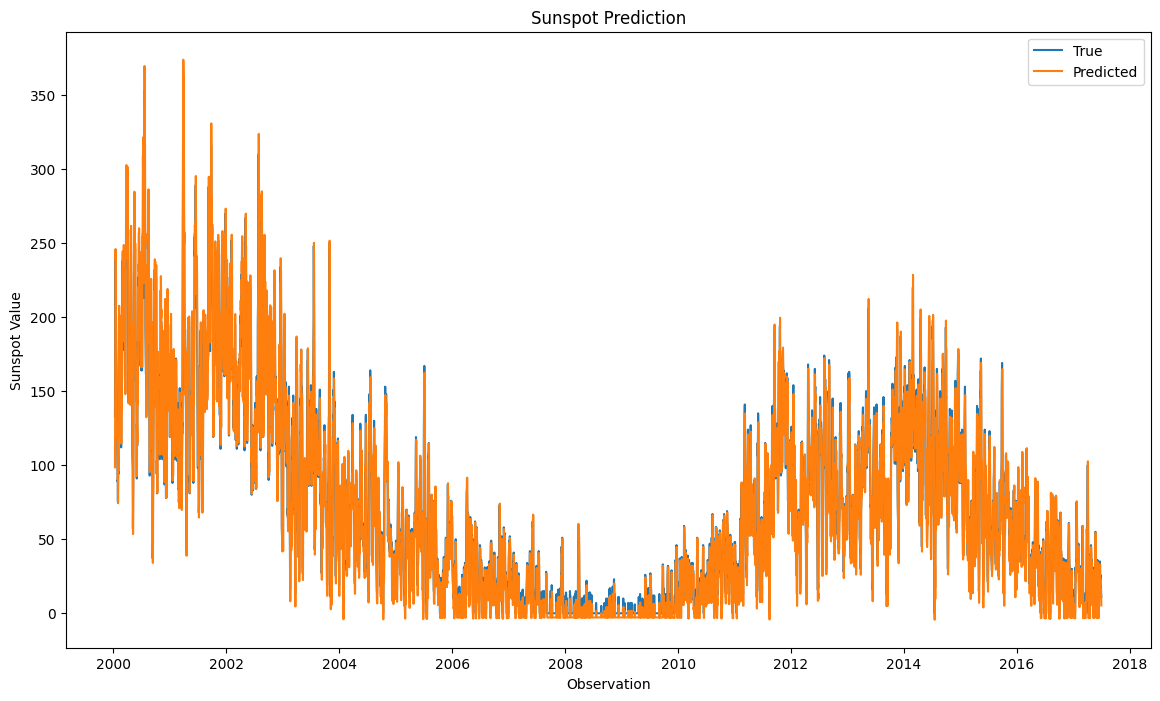

In [23]:
# Plot the true vs. predicted sunspot values
plt.figure(figsize=(14, 8))
plt.plot(test_indices, y_test_numpy, label='True')
plt.plot(test_indices, y_hat_test_inv, label='Predicted')
plt.title("Sunspot Prediction")
plt.xlabel("Observation")
plt.ylabel("Sunspot Value")
plt.legend()
plt.show()

# Inference

In [29]:
n_future = 50

x_inference = x_test[:1].to(device)
inference_start_date = test_indices[-1] + pd.DateOffset(days=1)
predictions = []
dates = []
model.eval()
with torch.no_grad():
    for n in range(n_future):
        outputs = model(x_inference)
        predictions.append(outputs.squeeze(0).item())
        dates.append(inference_start_date + pd.DateOffset(days=n))
        x_inference = torch.cat([x_inference[:, 1:], outputs.unsqueeze(0)], dim=1)
predictions_inv = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

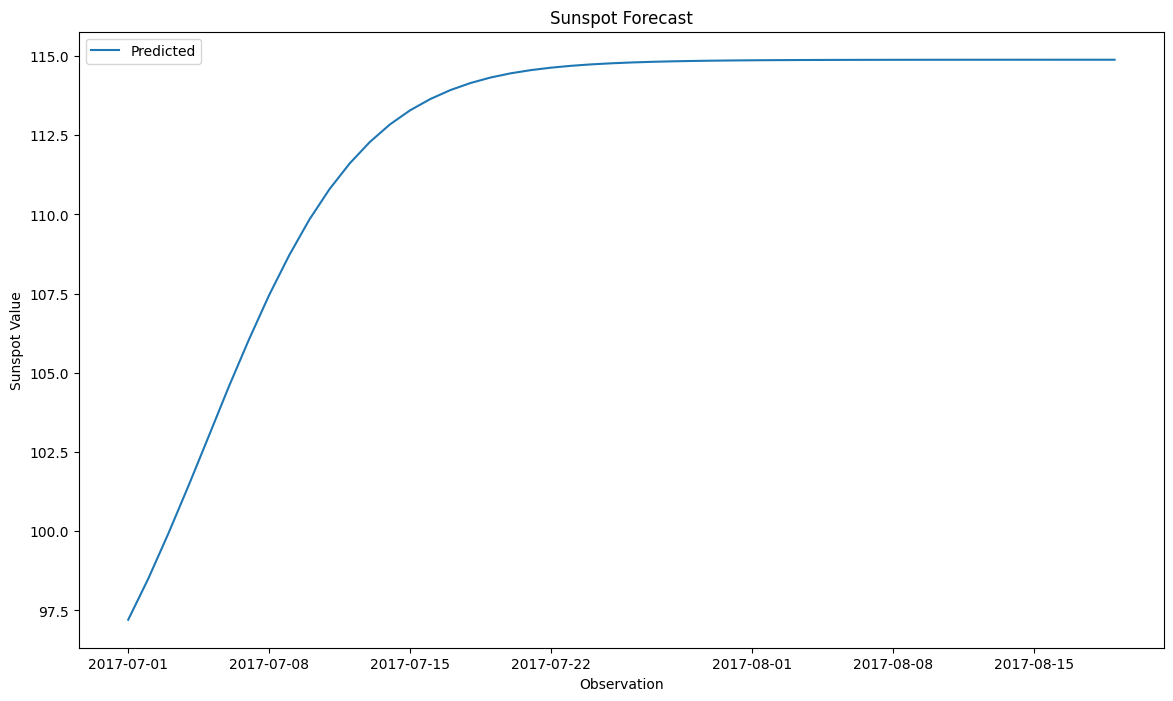

In [30]:
# Plot the predicted sunspot values
plt.figure(figsize=(14, 8))
plt.plot(dates, predictions_inv, label='Predicted')
plt.title("Sunspot Forecast")
plt.xlabel("Observation")
plt.ylabel("Sunspot Value")
plt.legend()
plt.show()